In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [9]:
train_dir = Path(r"E:\dataset\Food Dataset\train")
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [10]:
test_dir = Path(r"E:\dataset\Food Dataset\test")
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [11]:
val_dir = Path(r"E:\dataset\Food Dataset\validation")
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [19]:
import os
import pandas as pd

def image_processing(filepath):
    # Check if the list is not empty
    if not filepath:
        raise ValueError("Empty filepath list")

    # Print debugging information
    print("Length of filepath list:", len(filepath))
    
    # Extract labels from file paths
    labels = []
    for i in range(len(filepath)):
        try:
            # Use os.path to handle path manipulations
            label = os.path.basename(os.path.dirname(filepath[i]))
            labels.append(label)
        except IndexError:
            print(f"Error processing element at index {i}: {filepath[i]}")
            raise

    # Create a DataFrame with Filepath and Label columns
    df = pd.DataFrame({'Filepath': filepath, 'Label': labels})

    # Shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [26]:
train_df['Filepath'] = train_df['Filepath'].astype(str)
test_df['Filepath'] = test_df['Filepath'].astype(str)
val_df['Filepath'] = val_df['Filepath'].astype(str)

In [27]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['peas' 'grapes' 'capsicum' 'garlic' 'kiwi' 'spinach' 'cucumber' 'onion'
 'soy beans' 'chilli pepper' 'cabbage' 'carrot' 'orange' 'bell pepper'
 'turnip' 'sweetcorn' 'corn' 'jalepeno' 'ginger' 'cauliflower' 'lettuce'
 'watermelon' 'beetroot' 'pear' 'tomato' 'potato' 'apple' 'eggplant'
 'lemon' 'mango' 'sweetpotato' 'paprika' 'pineapple' 'banana'
 'pomegranate' 'raddish']


In [28]:
train_df.head(5)

,Filepath,Label
0,E:\dataset\Food Dataset\train\peas\Image_90.jpg,peas
1,E:\dataset\Food Dataset\train\grapes\Image_35.jpg,grapes
2,E:\dataset\Food Dataset\train\capsicum\Image_1...,capsicum
3,E:\dataset\Food Dataset\train\grapes\Image_81.jpg,grapes
4,E:\dataset\Food Dataset\train\garlic\Image_34.jpg,garlic


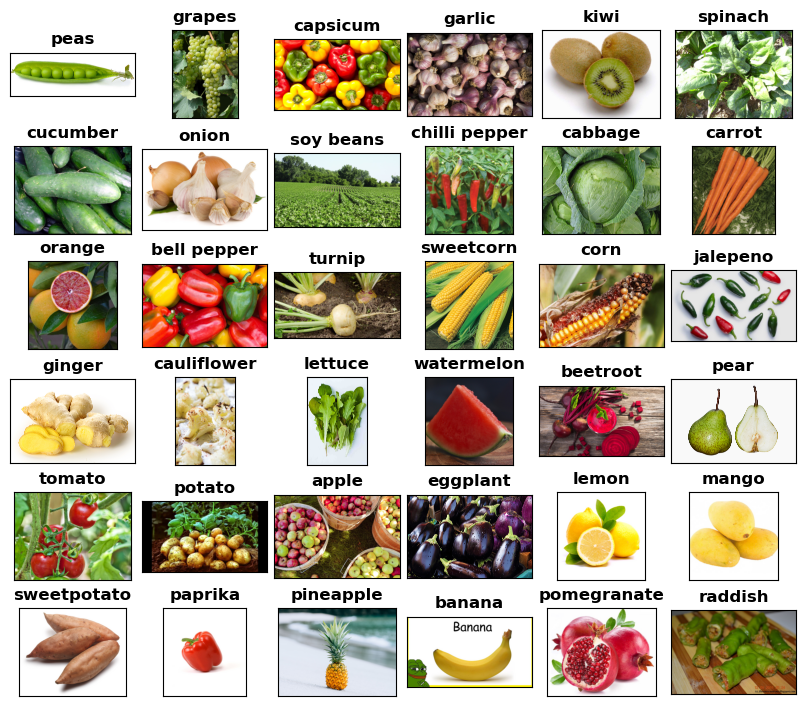

In [29]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [30]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [38]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [39]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [40]:
weights_path = "E:\dataset\Food Dataset\mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

In [41]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=weights_path,  
    pooling='avg'
)

pretrained_model.trainable = False

In [42]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


90/90 [==============================] - 167s 2s/step - loss: 1.7156 - accuracy: 0.5426 - val_loss: 0.4688 - val_accuracy: 0.8500
Epoch 2/5
90/90 [==============================] - 131s 1s/step - loss: 0.5523 - accuracy: 0.8266 - val_loss: 0.2896 - val_accuracy: 0.8971
Epoch 3/5
90/90 [==============================] - 132s 1s/step - loss: 0.3521 - accuracy: 0.8802 - val_loss: 0.2358 - val_accuracy: 0.9294
Epoch 4/5
90/90 [==============================] - 133s 1s/step - loss: 0.2101 - accuracy: 0.9370 - val_loss: 0.1802 - val_accuracy: 0.9559
Epoch 5/5
90/90 [==============================] - 137s 2s/step - loss: 0.1446 - accuracy: 0.9569 - val_loss: 0.1990 - val_accuracy: 0.9588


In [43]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 22s 2s/step


['mango',
 'sweetcorn',
 'pineapple',
 'turnip',
 'banana',
 'spinach',
 'jalepeno',
 'eggplant',
 'jalepeno',
 'watermelon',
 'capsicum',
 'paprika',
 'lettuce',
 'grapes',
 'sweetcorn',
 'lettuce',
 'eggplant',
 'tomato',
 'paprika',
 'grapes',
 'carrot',
 'pomegranate',
 'pineapple',
 'potato',
 'turnip',
 'mango',
 'raddish',
 'ginger',
 'potato',
 'potato',
 'onion',
 'kiwi',
 'cucumber',
 'pomegranate',
 'spinach',
 'lemon',
 'spinach',
 'jalepeno',
 'pomegranate',
 'sweetpotato',
 'soy beans',
 'orange',
 'mango',
 'jalepeno',
 'sweetpotato',
 'ginger',
 'pear',
 'banana',
 'soy beans',
 'peas',
 'orange',
 'cauliflower',
 'beetroot',
 'grapes',
 'soy beans',
 'cabbage',
 'ginger',
 'cabbage',
 'beetroot',
 'orange',
 'lettuce',
 'cabbage',
 'pear',
 'watermelon',
 'ginger',
 'capsicum',
 'lemon',
 'watermelon',
 'raddish',
 'watermelon',
 'tomato',
 'turnip',
 'cabbage',
 'tomato',
 'peas',
 'spinach',
 'cucumber',
 'grapes',
 'bell pepper',
 'tomato',
 'lettuce',
 'pineapple',

In [44]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

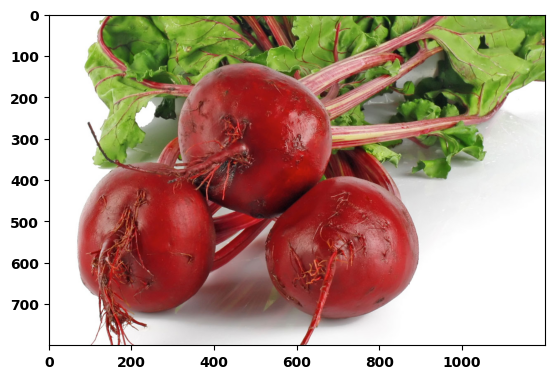

1/1 [==============================] - 0s 40ms/step


'beetroot'

In [53]:
import matplotlib.image as mpimg

img_path = r"E:\dataset\Food Dataset\test\beetroot\Image_5.jpg"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

img = output(r"E:\dataset\Food Dataset\test\beetroot\Image_5.jpg")
img

In [54]:
import requests
import json

api_url = 'https://api.api-ninjas.com/v1/nutrition?query={}'.format(img)
response = requests.get(api_url, headers={'X-Api-Key': 'FJCuuMBu83nEaI7CGroR8A==z88oB9CslsPk9p80'})
if response.status_code == requests.codes.ok:
    employee_string = response.text
    json_object = json.loads(employee_string)
    print(json.dumps(json_object[0], indent=4))
else:
    print("Error:", response.status_code, response.text)

{
    "name": "beetroot",
    "calories": 45.2,
    "serving_size_g": 100.0,
    "fat_total_g": 0.2,
    "fat_saturated_g": 0.0,
    "protein_g": 1.7,
    "sodium_mg": 76,
    "potassium_mg": 38,
    "cholesterol_mg": 0,
    "carbohydrates_total_g": 10.0,
    "fiber_g": 2.0,
    "sugar_g": 8.0
}


In [55]:
model.save('Food_Estimation.h5')